# Scraping data from https://www.flightradar24.com/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import time

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

driver = webdriver.Chrome(r'C:\Users\User\Anaconda3\Lib\chromedriver.exe')

In [4]:
import os
data_path = r'C:\Users\User\Desktop\j\Python\data_sets'
all_traffic = pd.read_csv(os.path.join(data_path, 'total-number-of-flights.csv'), index_col='DateTime', 
                          parse_dates=True)

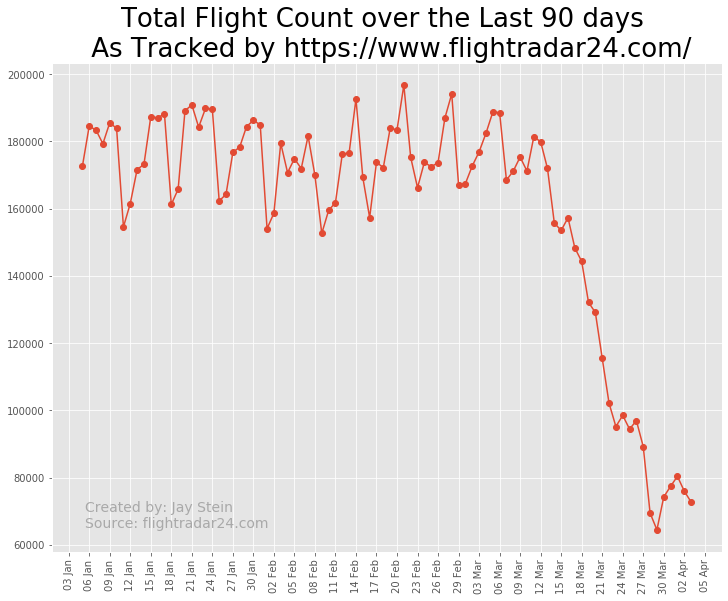

In [14]:
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(12,9))

#control over date intervals and format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax.plot(all_traffic['Number of flights'], marker='o')
plt.xticks(rotation=90), 
plt.title('Total Flight Count over the Last 90 days \n As Tracked by https://www.flightradar24.com/', fontsize=26)
ax.text(0.05, 0.05, 'Created by: Jay Stein \nSource: flightradar24.com', transform=ax.transAxes, c='darkgrey', fontsize=14);
#Total flights = Commercial flights above + rest of business jet flights + private flights + gliders + 
#most helicopter flights + most ambulance flights + government flights + some military flights + drones;

In [6]:
#scrape flightradar24 to get airport stats for world's busiest airports

def get_airport_data(airport_code):
    url = r'https://www.flightradar24.com/data/airports/' + airport_code + r'/statistics'
    time.sleep(5)
    
    #use selenium to get data
    driver.get(url)
    tracked = driver.execute_script('return window.Highcharts.charts[0].series[1].options.data')
    scheduled = driver.execute_script('return window.Highcharts.charts[0].series[0].options.data')
    
    #convert list to data frame
    tracked = pd.DataFrame(tracked,columns=['date','tracked' + '-' + airport_code])
    scheduled = pd.DataFrame(scheduled, columns=['date','scheduled' + '-' + airport_code])

    #convert unix timestamp to regular date time
    tracked_clean = tracked.set_index(pd.to_datetime(tracked['date'], unit='ms')).drop(columns='date').sort_index()
    scheduled_clean = scheduled.set_index(pd.to_datetime(scheduled['date'], unit='ms')).drop(columns='date').sort_index()
    
    #merge the two frames
    merged_df = tracked_clean.join(scheduled_clean)
    
    return merged_df

In [7]:
airport_list = ['ATL', 'PEK', 'DXB', 'LAX', 'HND', 'ORD', 'LHR', 'HKG', 'PVG', 'CDG', 'AMS', 'DEL', 'SYD']

In [8]:
airport_countries = ['USA', 'China', 'UAE', 'USA', 'Japan', 'USA', 'UK', 'HK', 'China', 'France', 'Netherlands', 'India', 'Australia']

In [9]:
#merge the two into a dictionary - I am sure this could have been done easier!
airport_countries_dash = ['-' + country for country in airport_countries]

#create list of labels for plots
label_list = list(map(str.__add__, airport_list, airport_countries_dash))

label_list_dict = dict(zip(airport_list, label_list))

In [10]:
#instantiate blank data frames
df=[]
df_final=[]

for airport in airport_list:
    df = get_airport_data(airport)
    df_final = df.join(df_final)

In [11]:
#create label for the plot legend
legend_label = list(df_final.filter(like='track').columns.str.replace('tracked-','').str.upper().map(label_list_dict))

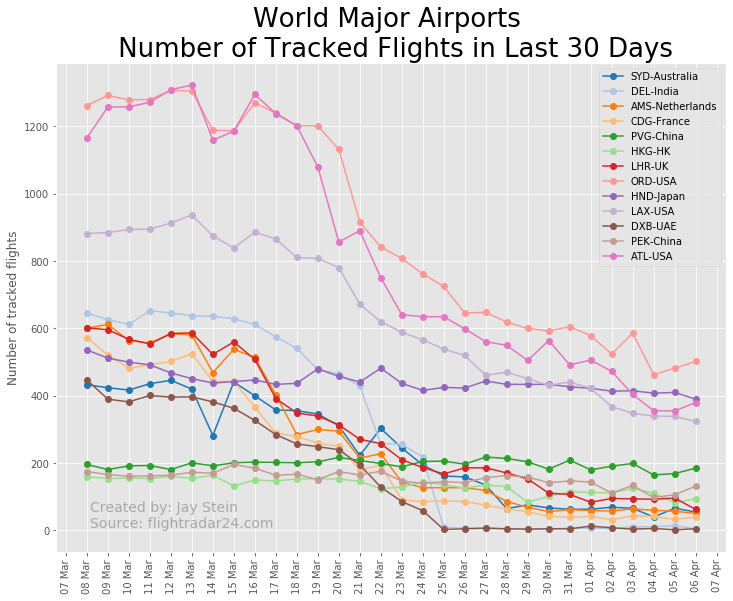

In [18]:
#show absolute count of flights - last 30 days

fig, ax = plt.subplots(figsize=(12,9))
ax.set_prop_cycle('color',plt.cm.tab20.colors) #colormap
ax.plot(df_final.filter(like='track'), marker='o')
plt.legend(labels = legend_label)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.xticks(rotation=90)
plt.ylabel('Number of tracked flights')
plt.title('World Major Airports \n Number of Tracked Flights in Last 30 Days', fontsize=26)
ax.text(0.05, 0.05, 'Created by: Jay Stein \nSource: flightradar24.com', transform=ax.transAxes, c='darkgrey', fontsize=14)
plt.savefig('covid19-2.jpg', bbox_inches='tight', dpi=400, pad_inches=0, format='jpg');

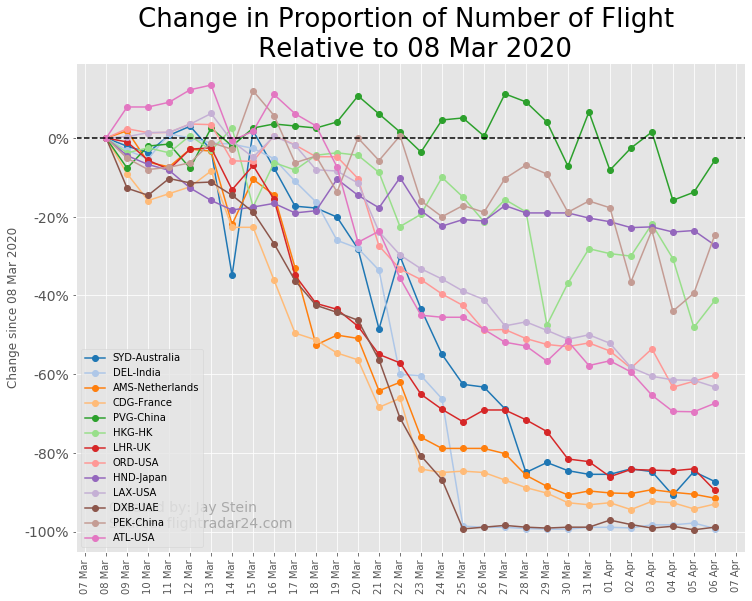

In [21]:
#plotting the delta pct - last 30 days
from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(figsize=(12,9))

df_delta = df_final.filter(like='track').apply(lambda x: x.pct_change().fillna(0).add(1).cumprod().sub(1))

ax.set_prop_cycle('color',plt.cm.tab20.colors) #colormap
plt.plot(df_delta, marker='o')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.xticks(rotation=90)
plt.yticks(fontsize=14)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))   #percentage
plt.legend(legend_label)
plt.title('Change in Proportion of Number of Flight \n Relative to ' + \
          df_delta.index[0].strftime('%d %b %Y'), 
         fontsize=26)
ax.axhline(y=0, c='k', ls='--')
plt.ylabel('Change since ' + df_delta.index[0].strftime('%d %b %Y'))
ax.text(0.05, 0.05, 'Created by: Jay Stein \nSource: flightradar24.com', transform=ax.transAxes, c='darkgrey', fontsize=14);
plt.savefig('covid19-3.jpg', bbox_inches='tight', dpi=400, pad_inches=0, format='jpg');